In [114]:
import pandas as pd
from pylab import mpl, plt
import yfinance as yf
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [115]:
# Télécharger les données historiques du Bitcoin (BTC-USD)
btc_data = yf.download("BTC-USD", start="2018-01-01", end="2024-04-30")
# Afficher les premières lignes pour vérifier
data=btc_data['Adj Close'].to_frame(name='price')

[*********************100%%**********************]  1 of 1 completed


## Strategies based on Momentum

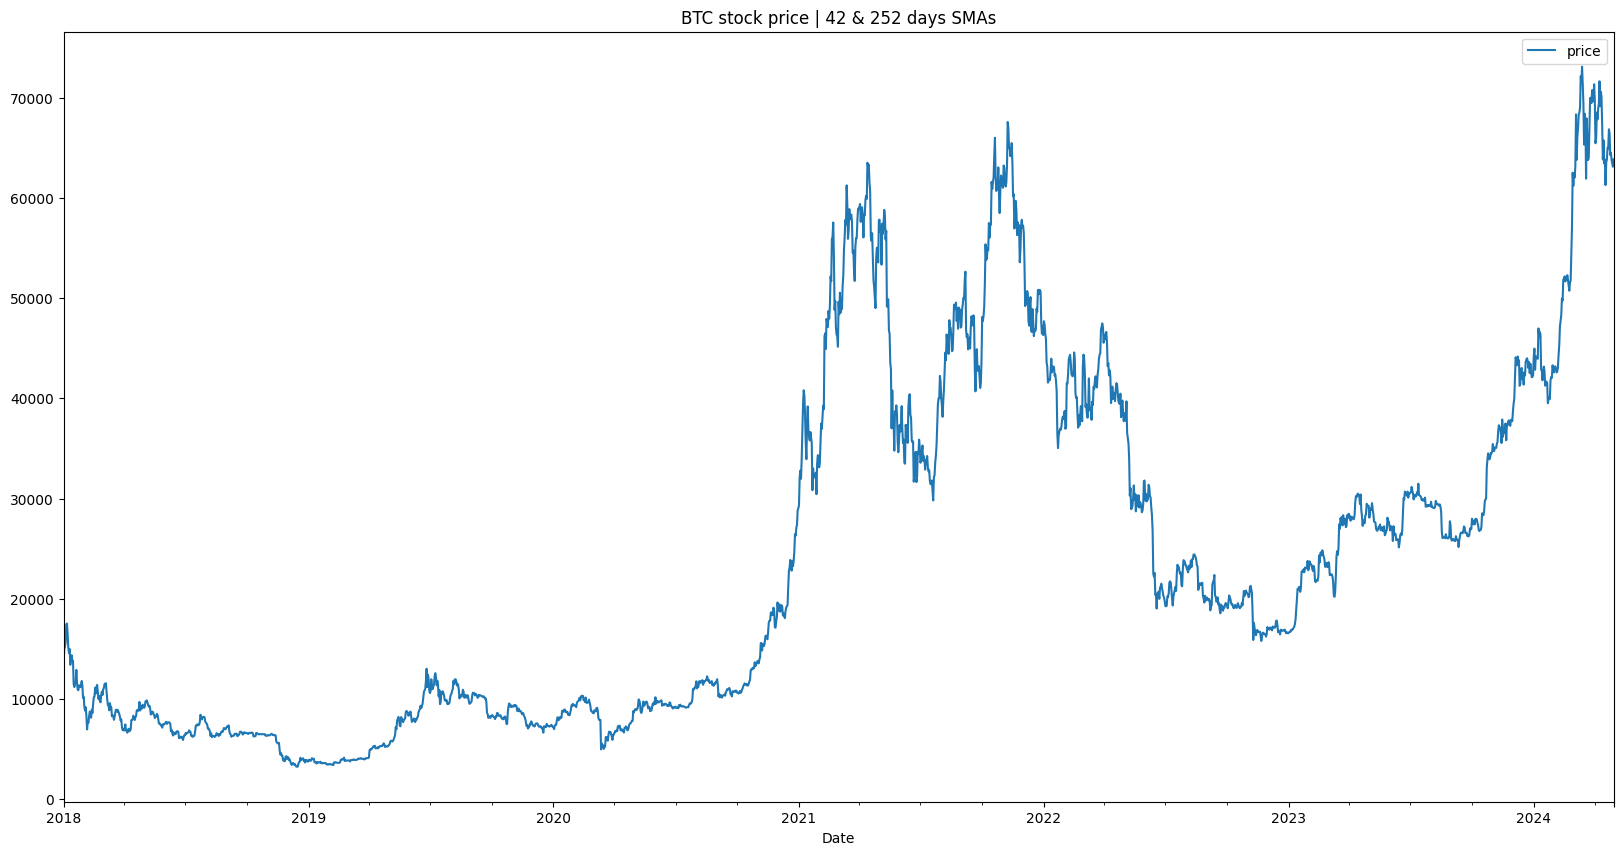

In [116]:
data.plot(title='BTC stock price | 42 & 252 days SMAs',
          figsize=(20, 10));

In [117]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [118]:
to_plot = ['returns']
for m in [1, 3, 5, 7, 9]:
    data['position_%d' % m] = np.sign(data['returns'].rolling(m).mean())
    data['strategy_%d' % m] = (data['position_%d' % m].shift(1) *
                               data['returns'])
    to_plot.append('strategy_%d' % m) 

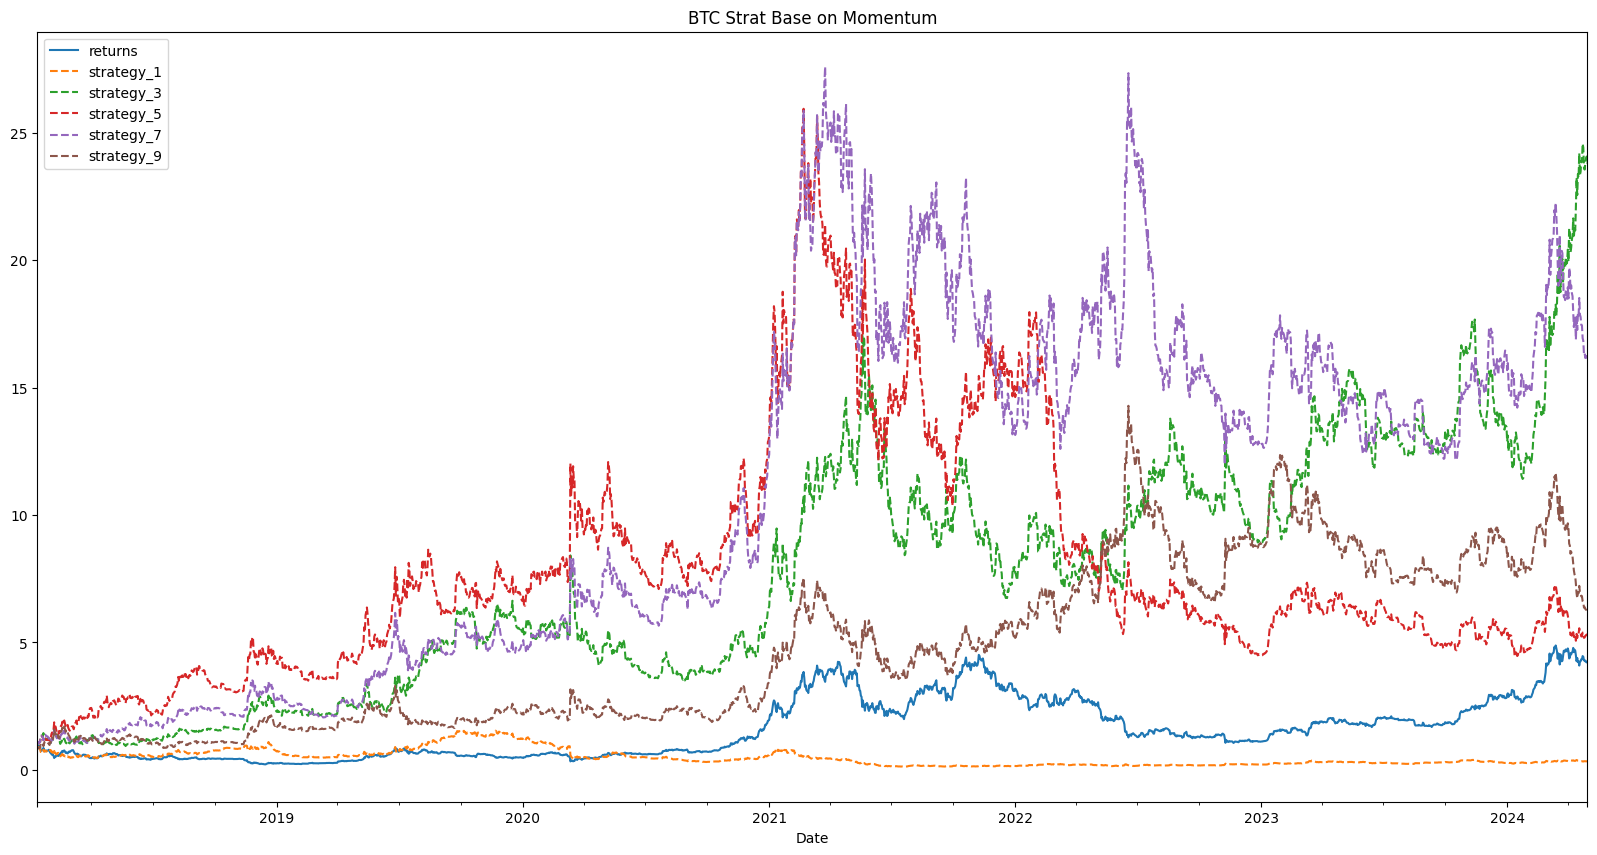

In [119]:
data[to_plot].dropna().cumsum().apply(np.exp).plot(
    title='BTC Strat Base on Momentum',
    figsize=(20, 10), style=['-', '--', '--', '--', '--', '--'])
plt.savefig('BTC_Momentum_Strategy.png')

### Using Logistic Regression to Predict Market Direction

In [120]:
from sklearn import linear_model

In [121]:
data=btc_data['Adj Close'].to_frame(name='price')

In [122]:
data['return'] = np.log(data['price'] / data['price'].shift(1))

In [123]:
data.dropna(inplace=True)

In [139]:
lags = 5

In [140]:
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['return'].shift(lag)
    cols.append(col)

In [141]:
data.dropna(inplace=True)

In [142]:
data

,price,return,lag_1,lag_2,lag_3,lag_4,prediction,strategy,lag_5
Date,,,,,,,,,
2018-01-11,13405.799805,-0.110581,0.025562,-0.038620,-0.082675,-0.061741,-1.0,0.110581,0.005578
2018-01-12,13980.599609,0.041983,-0.110581,0.025562,-0.038620,-0.082675,1.0,0.041983,-0.061741
2018-01-13,14360.200195,0.026790,0.041983,-0.110581,0.025562,-0.038620,-1.0,-0.026790,-0.082675
2018-01-14,13772.000000,-0.041823,0.026790,0.041983,-0.110581,0.025562,-1.0,0.041823,-0.038620
2018-01-15,13819.799805,0.003465,-0.041823,0.026790,0.041983,-0.110581,1.0,0.003465,0.025562
...,...,...,...,...,...,...,...,...,...
2024-04-25,64481.707031,0.003181,-0.032606,-0.006460,0.029009,-0.001044,1.0,0.003181,0.017866
2024-04-26,63755.320312,-0.011329,0.003181,-0.032606,-0.006460,0.029009,1.0,-0.011329,-0.001044
2024-04-27,63419.140625,-0.005287,-0.011329,0.003181,-0.032606,-0.006460,1.0,-0.005287,0.029009


In [143]:
from sklearn.metrics import accuracy_score

In [144]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)

In [145]:
lm.fit(data[cols], np.sign(data['return']))

LogisticRegression(C=10000000.0, max_iter=1000)

In [146]:
data['prediction'] = lm.predict(data[cols])

In [147]:
data['prediction'].value_counts()

prediction
 1.0    1644
-1.0     657
Name: count, dtype: int64

In [148]:
hits = np.sign(data['return'].iloc[lags:] *
               data['prediction'].iloc[lags:]
              ).value_counts()

In [149]:
hits

 1.0    1221
-1.0    1075
Name: count, dtype: int64

In [150]:
accuracy_score(data['prediction'],
               np.sign(data['return']))

0.5323772272924815

In [151]:
data['strategy'] = data['prediction'] * data['return']

In [152]:
data[['return', 'strategy']].sum().apply(np.exp)

return      4.263664
strategy    6.123480
dtype: float64

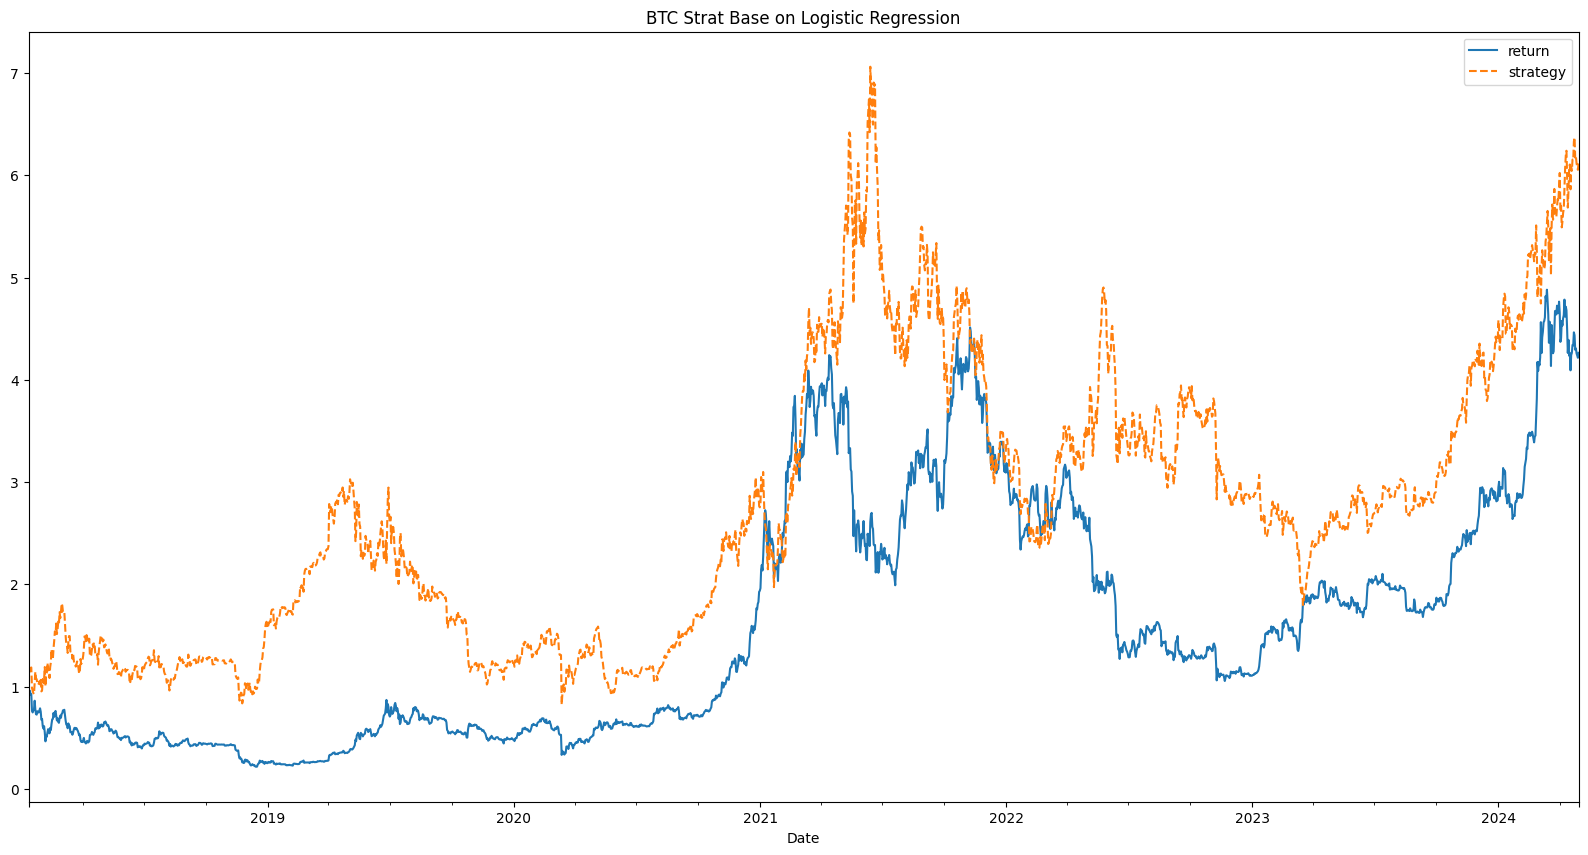

In [154]:
data[['return', 'strategy']].cumsum().apply(np.exp).plot(title='BTC Strat Base on Logistic Regression',
                                        figsize=(20, 10),style=['-', '--']);
plt.savefig('BTC_LR_Strategy.png')